In [32]:
import sqlite3
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np


In [33]:
conn = sqlite3.connect("../../places.sqlite")

full_data = pd.read_sql_query(
    """
SELECT 
	moz_places.url as url,
    moz_historyvisits.'visit_date' as 'visit_date'
from moz_historyvisits
    join moz_places on moz_places.id = moz_historyvisits.place_id;
    
""",
    conn,
)

# region 1

# full_data = pd.read_sql_query(
#     """
# SELECT
# 	moz_places.url as pl_url,
#     moz_places.visit_count as pl_visit_count,
#     moz_places.frecency as pl_url_frecency,
#     moz_places.last_visit_date as pl_last_visit_date,
#     moz_historyvisits.'from_visit' as 'his_from_visit',
#     moz_historyvisits.'visit_date' as 'his_visit_date',
#     moz_historyvisits.'visit_type' as 'his_visit_type'
# from moz_historyvisits
#     join moz_places on moz_places.id = moz_historyvisits.place_id;

# """,
#     conn,
# )

# endregion

# full_data[full_data["visit_count"] == 0] = 1


In [34]:
full_data.head()


,url,visit_date
0,https://spins.fedoraproject.org/,1652190849558000
1,https://spins.fedoraproject.org/,1654098416035000
2,https://spins.fedoraproject.org/,1656856015277000
3,https://spins.fedoraproject.org/,1666263920924000
4,https://spins.fedoraproject.org/,1668600233996000


In [35]:
import csv
import re

full_data["host"] = full_data["url"].map(
    lambda x: re.match(r"https?:\/\/(([^/]+\.)+[^/]+)", x).group(1)
    if re.match(r"https?:\/\/(([^/]+\.)+[^/]+)", x) is not None
    else pd.NA
)


full_data.to_csv("full_data.csv", index=False, quoting=csv.QUOTE_ALL)
full_data["host"].isna().sum()


2229

In [36]:
from datetime import datetime

full_data["visit_date_obj"] = full_data["visit_date"].map(
    lambda x: datetime.fromtimestamp(x / 1000000)
)


In [37]:
full_data.drop("url", axis=1, inplace=True)
full_data["visit_count"] = 1

full_data.dropna(axis=0, how="any", inplace=True)
full_data.reset_index(inplace=True, drop=True)

full_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66210 entries, 0 to 66209
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   visit_date      66210 non-null  int64         
 1   host            66210 non-null  object        
 2   visit_date_obj  66210 non-null  datetime64[ns]
 3   visit_count     66210 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.0+ MB


In [38]:
full_data.head()


,visit_date,host,visit_date_obj,visit_count
0,1652190849558000,spins.fedoraproject.org,2022-05-10 13:54:09.558,1
1,1654098416035000,spins.fedoraproject.org,2022-06-01 15:46:56.035,1
2,1656856015277000,spins.fedoraproject.org,2022-07-03 13:46:55.277,1
3,1666263920924000,spins.fedoraproject.org,2022-10-20 11:05:20.924,1
4,1668600233996000,spins.fedoraproject.org,2022-11-16 12:03:53.996,1


In [39]:
time_frames = {
    "morning": (5, 11),
    "afternoon": (11, 17),
    "evening": (17, 23),
    # "night": (23, 5),
}

modified_data = pd.DataFrame()

modified_data["host"] = full_data["host"].unique()

for time_frame, (start, end) in time_frames.items():
    modified_data = modified_data.merge(
        full_data[
            (
                (full_data["visit_date_obj"].dt.hour >= start)
                & (full_data["visit_date_obj"].dt.hour < end)
            )
        ]
        .groupby("host")
        .agg({"visit_count": "sum"})
        .rename(columns={"visit_count": f"visits_{time_frame}"})
        .astype({f"visits_{time_frame}": pd.Int64Dtype()})
        .reset_index(),
        on="host",
        how="left",
    )

modified_data = modified_data.merge(
    full_data[
        (
            (full_data["visit_date_obj"].dt.hour < 5)
            | (full_data["visit_date_obj"].dt.hour <= 23)
        )
    ]
    .groupby("host")
    .agg({"visit_count": "sum"})
    .rename(columns={"visit_count": f"visits_night"})
    .astype({f"visits_night": pd.Int64Dtype()})
    .reset_index(),
    on="host",
    how="left",
)

modified_data["total_visits"] = modified_data[
    ["visits_morning", "visits_afternoon", "visits_evening", "visits_night"]
].sum(axis=1)

modified_data = modified_data.fillna(0)

modified_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2180 entries, 0 to 2179
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   host              2180 non-null   object
 1   visits_morning    2180 non-null   Int64 
 2   visits_afternoon  2180 non-null   Int64 
 3   visits_evening    2180 non-null   Int64 
 4   visits_night      2180 non-null   Int64 
 5   total_visits      2180 non-null   int64 
dtypes: Int64(4), int64(1), object(1)
memory usage: 110.8+ KB


In [40]:
modified_data.head()


,host,visits_morning,visits_afternoon,visits_evening,visits_night,total_visits
0,spins.fedoraproject.org,4,10,0,14,28
1,www.redhat.com,37,75,2,117,231
2,www.wikipedia.org,2,2,1,5,10
3,www.mozilla.org,3,1,0,4,8
4,addons.mozilla.org,57,50,25,133,265


In [41]:
selected_data = modified_data.sort_values(by="total_visits", ascending=False).iloc[:15]

# 'host',	'host_frecency',	'total_visits',	'visits_morning',	'visits_afternoon',	'visits_evening',	'visits_night'

# Melt the dataset to combine "visits_morning," "visits_afternoon," etc. into a "time" column
selected_data = selected_data.melt(
    id_vars=["host", "total_visits"],
    value_vars=["visits_morning", "visits_afternoon", "visits_evening", "visits_night"],
    var_name="visit_TOD",
    value_name="visit_count_TOD",
)

selected_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   host             60 non-null     object
 1   total_visits     60 non-null     int64 
 2   visit_TOD        60 non-null     object
 3   visit_count_TOD  60 non-null     Int64 
dtypes: Int64(1), int64(1), object(2)
memory usage: 2.1+ KB


/home/ubuntu/FDS/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


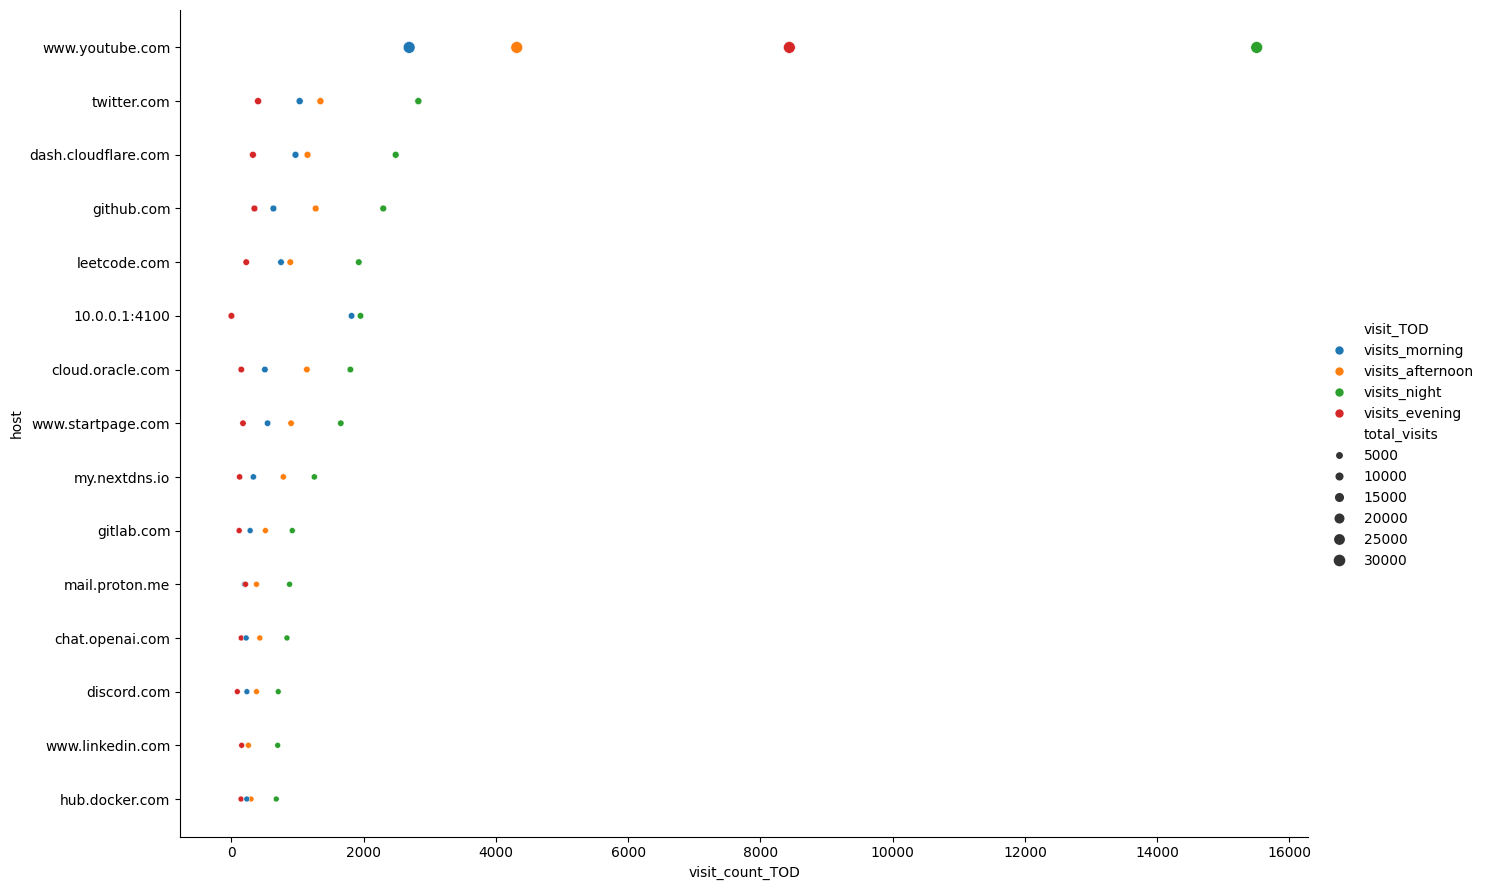

In [42]:
ax = sns.relplot(
    x="visit_count_TOD",
    y="host",
    data=selected_data.sort_values(by="total_visits", ascending=False),
    hue="visit_TOD",
    size="total_visits",
    height=9,
    aspect=1.5,
    legend="brief",
)

# ax.set_xticklabels(rotation=90, ha="right", fontsize=8.5, y=1)

plt.show()


# Part 2

In [43]:
conn = sqlite3.connect("../../places.sqlite")

data_2 = pd.read_sql_query(
    """
SELECT moz_historyvisits.id,
    moz_places.url as url,
    moz_historyvisits.'visit_date' as 'visit_date',
    moz_historyvisits.from_visit as from_visit,
    NULL AS from_url
FROM moz_historyvisits
    JOIN moz_places ON moz_places.id = moz_historyvisits.place_id
WHERE moz_historyvisits.from_visit NOT IN (
        SELECT id
        FROM moz_historyvisits
    )
UNION
SELECT moz_historyvisits.id,
    moz_places.url as url,
    moz_historyvisits.'visit_date' as 'visit_date',
    moz_historyvisits.from_visit as from_visit,
    t2.url as from_url
FROM moz_historyvisits
    JOIN moz_places ON moz_places.id = moz_historyvisits.place_id
    JOIN (
        SELECT moz_historyvisits.id,
            moz_places.url as url
        FROM moz_historyvisits
            JOIN moz_places ON moz_places.id = moz_historyvisits.place_id
    ) AS t2 ON t2.id = moz_historyvisits.from_visit;
    
""",
    conn,
)


In [44]:
data_2.head()


,id,url,visit_date,from_visit,from_url
0,2,https://www.mozilla.org/en-US/privacy/firefox/,1685958651538450,1,None
1,4,https://addons.mozilla.org/en-US/firefox/searc...,1685958696631130,3,None
2,5,https://addons.mozilla.org/en-US/firefox/searc...,1685958697019279,4,https://addons.mozilla.org/en-US/firefox/searc...
3,6,https://addons.mozilla.org/en-US/firefox/addon...,1685958699268107,5,https://addons.mozilla.org/en-US/firefox/searc...
4,7,http://firefox.com/,1685958832055490,0,None


In [45]:
import csv
import re

data_2["host"] = data_2["url"].map(
    lambda x: re.match(r"https?:\/\/(([^/]+\.)+[^/]+)", x).group(1)
    if re.match(r"https?:\/\/(([^/]+\.)+[^/]+)", x) is not None
    else pd.NA
)

data_2["from_host"] = data_2["from_url"].map(
    lambda x: re.match(r"https?:\/\/(([^/]+\.)+[^/]+)", x).group(1)
    if x is not None and re.match(r"https?:\/\/(([^/]+\.)+[^/]+)", x) is not None
    else pd.NA
)

data_2["host"].isna().sum()


2229

In [46]:
from datetime import datetime

data_2["visit_date_obj"] = data_2["visit_date"].map(
    lambda x: datetime.fromtimestamp(x / 1000000)
)


In [47]:
data_2.drop("url", axis=1, inplace=True)
data_2.drop("from_url", axis=1, inplace=True)
data_2["visit_count"] = 1

data_2.dropna(axis=0, how="any", inplace=True)
data_2.reset_index(inplace=True, drop=True)

data_2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27229 entries, 0 to 27228
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              27229 non-null  int64         
 1   visit_date      27229 non-null  int64         
 2   from_visit      27229 non-null  int64         
 3   host            27229 non-null  object        
 4   from_host       27229 non-null  object        
 5   visit_date_obj  27229 non-null  datetime64[ns]
 6   visit_count     27229 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 1.5+ MB


In [48]:
data_2.head()


,id,visit_date,from_visit,host,from_host,visit_date_obj,visit_count
0,5,1685958697019279,4,addons.mozilla.org,addons.mozilla.org,2023-06-05 09:51:37.019279,1
1,6,1685958699268107,5,addons.mozilla.org,addons.mozilla.org,2023-06-05 09:51:39.268107,1
2,8,1685958833083090,7,firefox.com,firefox.com,2023-06-05 09:53:53.083090,1
3,9,1685958833572129,8,www.mozilla.org,firefox.com,2023-06-05 09:53:53.572129,1
4,10,1685958834207886,9,www.mozilla.org,www.mozilla.org,2023-06-05 09:53:54.207886,1


In [49]:
data_2 = data_2[["host", "from_host"]].merge(
    modified_data[["host", "total_visits"]],
    on="host",
    how="left",
)

data_2.head()


,host,from_host,total_visits
0,addons.mozilla.org,addons.mozilla.org,265
1,addons.mozilla.org,addons.mozilla.org,265
2,firefox.com,firefox.com,4
3,www.mozilla.org,firefox.com,8
4,www.mozilla.org,www.mozilla.org,8


In [50]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

host_encoder = LabelEncoder()
from_host_encoder = LabelEncoder()

full_encoder = LabelEncoder()
all_hosts = list(data_2["host"].unique())
all_hosts.extend(list(data_2["from_host"].unique()))
all_hosts = list(set(all_hosts))
all_hosts = np.array(all_hosts)

all_hosts_encoded = full_encoder.fit(all_hosts)


data_2["host_encoded"] = full_encoder.transform(data_2["host"])
data_2["from_host_encoded"] = full_encoder.transform(data_2["from_host"])


model_data = data_2[["host_encoded", "from_host_encoded", "total_visits"]]

model_data.head()


,host_encoded,from_host_encoded,total_visits
0,41,41,265
1,41,41,265
2,415,415,4
3,1188,415,8
4,1188,1188,8


In [51]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import multiprocessing


In [52]:
X = model_data[["from_host_encoded"]]
Y = model_data["host_encoded"]


SINGLE_RUN_TIME = 10  # seconds
PARELLES = 4
TOTAL_RUNS = 100

max_time_sec = TOTAL_RUNS * SINGLE_RUN_TIME / PARELLES

max_time_sec


250.0

def train_model(i, X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=i
    )
    forest = RandomForestClassifier(n_estimators=100, random_state=i)
    forest.fit(X_train, Y_train)
    score = forest.score(X_test, Y_test)
    return (i, score)


def get_best_model(X, Y):
    num_processes = multiprocessing.cpu_count()  # Number of CPU cores
    pool = multiprocessing.Pool(processes=num_processes)
    scores = pool.starmap(train_model, [(i, X, Y) for i in range(100)])
    pool.close()
    pool.join()
    return max(scores, key=lambda x: x[1])


best_state = get_best_model(X, Y)


In [53]:
# print(f"Best state: {best_state}")

# ranom_state = best_state[0]
ranom_state = 0

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=ranom_state
)
forest = RandomForestClassifier(n_estimators=100, random_state=ranom_state)
forest.fit(X_train, Y_train)


RandomForestClassifier(random_state=0)

In [54]:
# test the model & find r2 score
# forest.score(X_test, Y_test)

from sklearn.metrics import accuracy_score

Y_pred = forest.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(Y_test, Y_pred)
accuracy


0.8845023870730812

In [29]:
hosts = ["www.startpage.com"]
visits = []

# predict the host from the hosts list
from_hosts_encoded = full_encoder.transform(hosts)

from_hosts_encoded = np.concatenate([visits, from_hosts_encoded], axis=0)
from_hosts_encoded = from_hosts_encoded.reshape(1, -1)

from_hosts_encoded

val = forest.predict(from_hosts_encoded.reshape(1, -1))
full_encoder.inverse_transform(val)


# val = list(forest.predict(from_hosts_encoded.reshape(1, -1))[0])

# val = [(index + 1, value) for index, value in enumerate(val)]

# val.sort(key=lambda x: x[1], reverse=True)
# val = val[:5]

# res = [
#     (full_encoder.inverse_transform(np.array([index])), value) for index, value in val
# ]

# res


# sorted_probs = np.argsort(probs[0])[::-1][:5]
# sorted_probs
# res = full_encoder.inverse_transform(sorted_probs)

# res


/home/ubuntu/FDS/.venv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array(['stackoverflow.com'], dtype='<U80')

In [67]:
# Assuming 'data_2' is your dataframe
# Encode the host names to numerical values
label_encoder = LabelEncoder()
data_2["from_host_encoded"] = label_encoder.fit_transform(data_2["from_host"])
data_2["host_encoded"] = label_encoder.transform(data_2["host"])

# Define the features and target variable
X = data_2[["from_host_encoded"]]
y = data_2["host_encoded"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Ensure that all labels in the test set are present in the training set
unseen_labels = set(y_test) - set(y_train)
X_test = X_test[~y_test.isin(unseen_labels)]
y_test = y_test[~y_test.isin(unseen_labels)]

# Create and train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict the top 5 most probable hosts
input_host_encoded = label_encoder.transform(
    ["www.youtube.com"]
)  # Encode the input host
probs = clf.predict_proba(input_host_encoded.reshape(1, -1))
top5_indices = np.argsort(probs[0])[::-1][
    :5
]  # Get the indices of the top 5 probabilities

# Get the actual host names from the indices
top5_hosts = label_encoder.inverse_transform(top5_indices)
print("Top 5 most probable hosts to be visited:", top5_hosts)


ValueError: y contains previously unseen labels: 'bugzilla.mozilla.org'